  calendar_dt                       id_employee  useful_calls_fact  \
0  2024-10-22  b85a5824cc3411e3429bd49054ffcc17               1225   
1  2024-10-22  611677896b031565a86d510977572ddf                  0   
2  2024-09-20  3506d80afbdc2f1ddcee2ce65e7d82ee                  0   
3  2024-12-25  a497350c6c8542c1e79ae2b83e6c782d              11483   
4  2024-09-20  34f30cdf1ab7f0195a74ef15963c29a5               1426   

   useful_chats_fact  avail_calls_fact  avail_chats_fact  \
0                  0              2542                 0   
1                  0                 0                 0   
2              21235                 0               372   
3              27466                 3               130   
4              30649               184              2119   

   avail_chat_call_fact  break_fact  education_fact  additional_fact  ...  \
0                     0           0           27598                0  ...   
1                     0           0               0             

KeyboardInterrupt: 

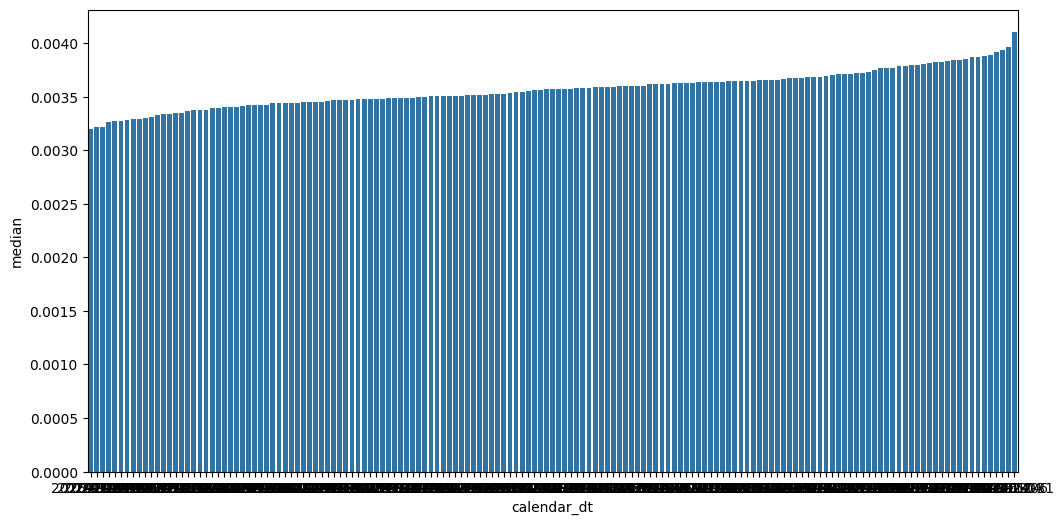

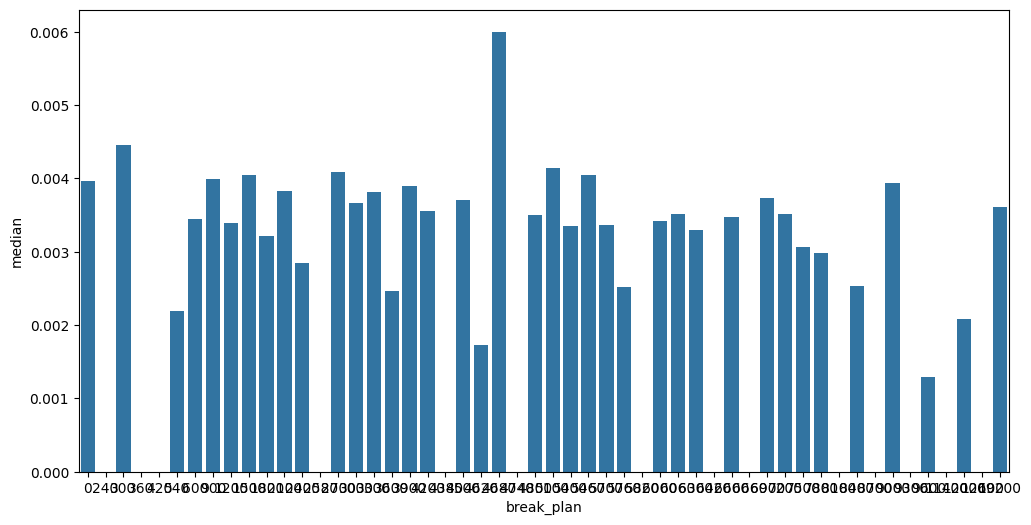

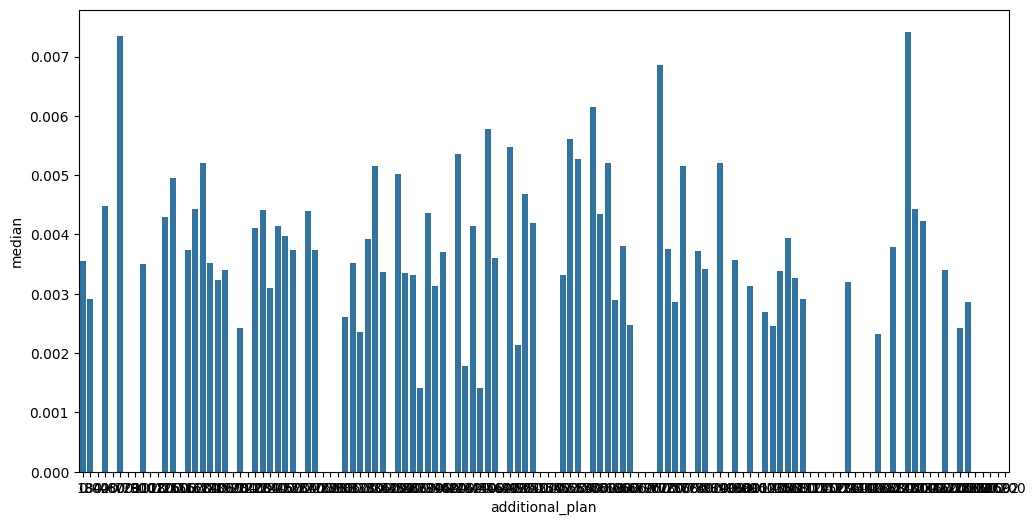

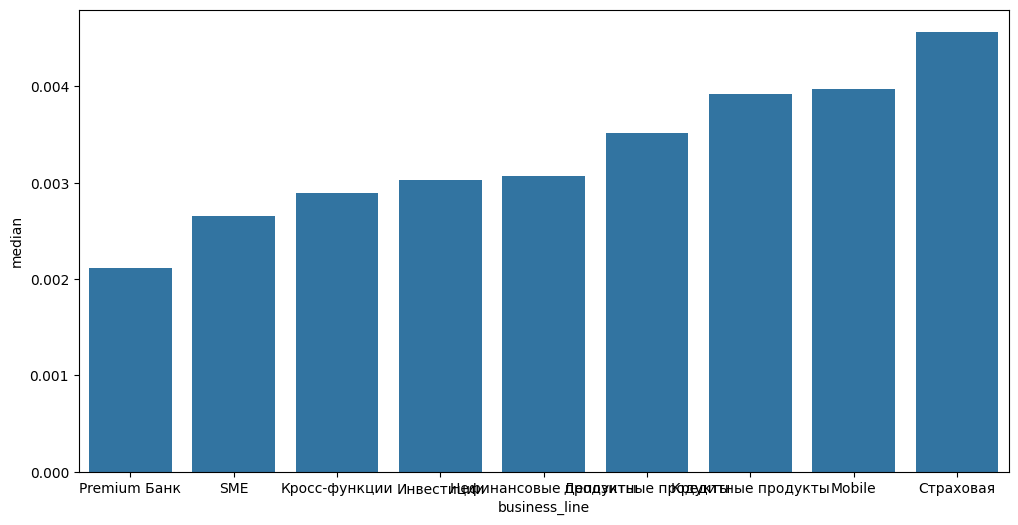

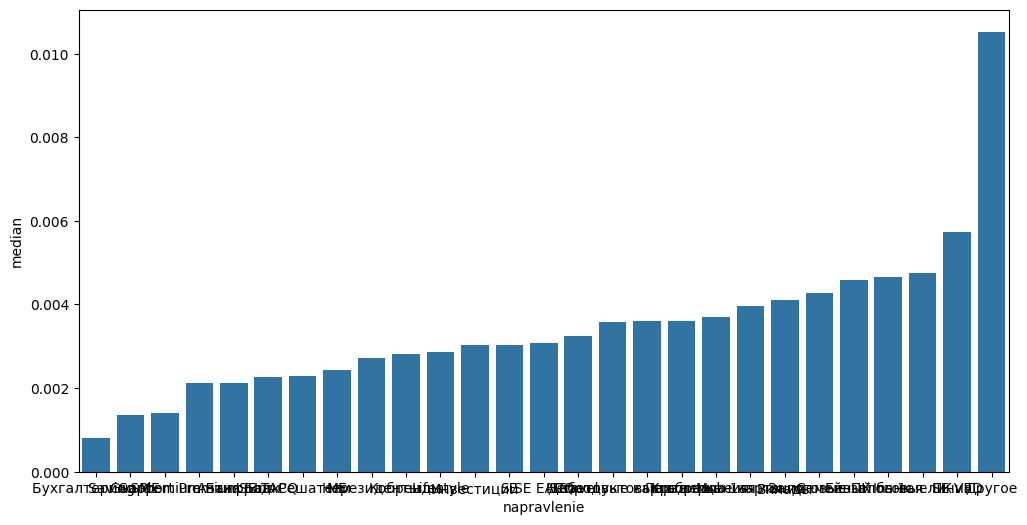

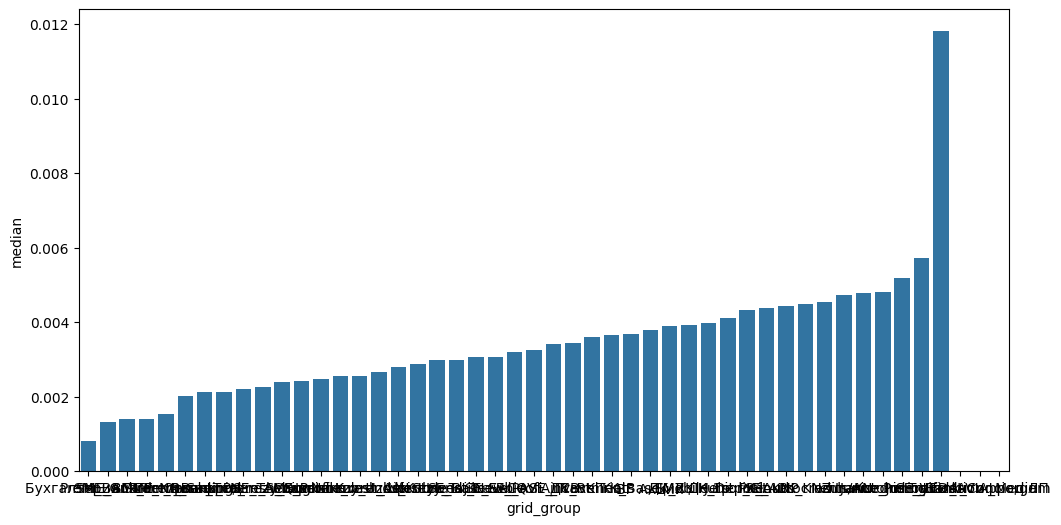

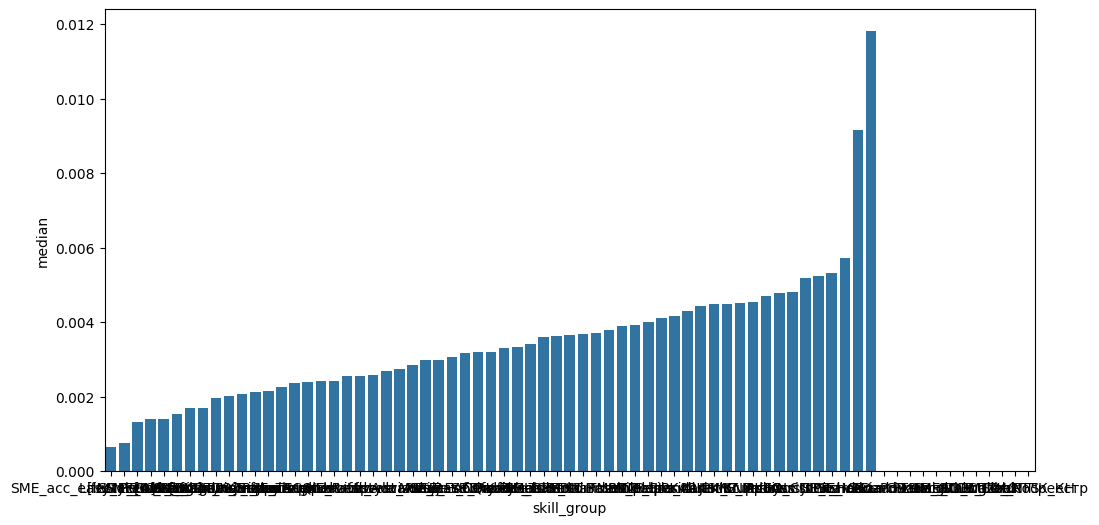

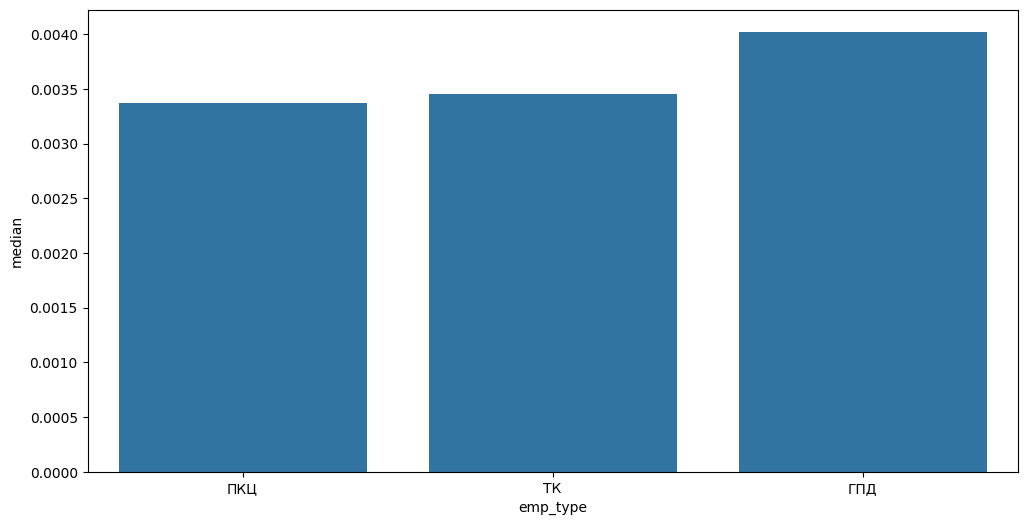

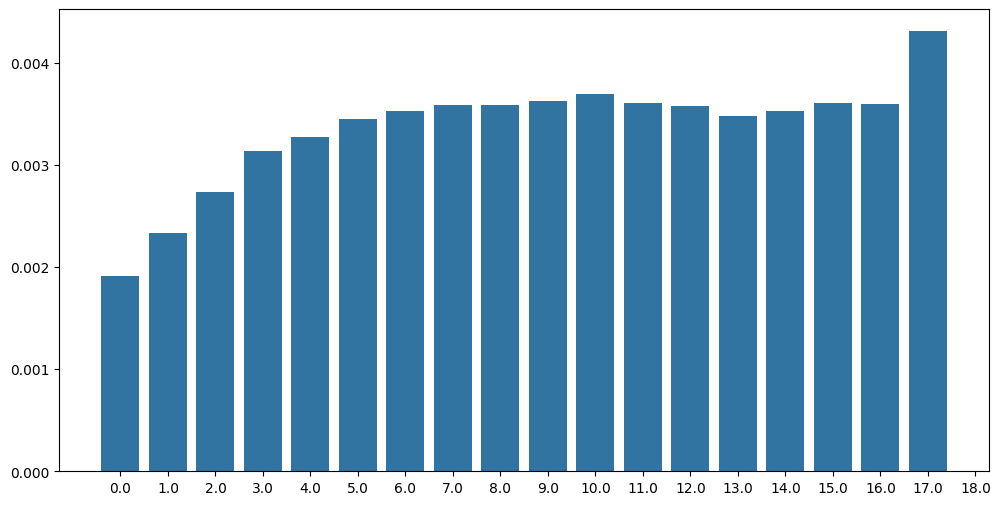

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
# Загрузка датасета
data = pd.read_excel('data.xlsx')
print(data.head())
print(len(data))
# Предположим, что у вас есть столбцы 'полезная_работа' и 'затраченная_энергия'
data['Эффективность'] = (data['useful_calls_fact'] + data['useful_calls_fact'] +  data['avail_calls_fact'] + data['avail_chats_fact'] + data['avail_chat_call_fact'] + data['education_fact'])/(data['useful_calls_fact'] + data['useful_calls_fact'] +  data['avail_calls_fact'] + data['avail_chats_fact'] + data['avail_chat_call_fact'] + data['education_fact'] + data['break_fact'] + data['additional_fact'])

data['Продуктивность'] = (data['cnt_call'] + data['cnt_chat'])/(data['dlg_time_call'] + data['dlg_time_chat'])

data['avg_help_time'] = 1 / data['Продуктивность']

def emp_type_flag(type):
    if type == 'ПКЦ':
        return 0
    elif type == 'ТК':
        return 1
    elif type == 'ГПД':
        return 2

def break_flag(break_fact):
    if break_fact > 0:
        return 1
    return 0

data['emp_type_flag'] = data['emp_type'].apply(emp_type_flag)

data['break_flag'] = data['break_fact'].apply(break_flag)


average_work_time = data.groupby('skill_group')['skill_group_exp'].mean().rename('average_work_time')

#data = data[data['residential_city_nm'] == 'г Москва']
# Добавляем новый столбец в исходный DataFrame
data = data.join(average_work_time, on='skill_group')

print(data.head())

def plot_eff_by_parameter(parameter_column):
    """
    Plot average productivity grouped by values of the given parameter column.
    
    Args:
        parameter_column: The column name to group by
    """
    # Skip if the parameter is 'Продуктивность' itself or if it's not a categorical column
    if parameter_column == 'Продуктивность' or data[parameter_column].nunique() > 200:
        return
    
    # Group by the parameter and calculate mean productivity
    grouped_data = data.groupby(parameter_column)['Продуктивность'].agg(['median', 'count']).reset_index()
    
    # Sort by mean productivity for better visualization
    grouped_data = grouped_data.sort_values('median')
    
    # Create figure
    plt.figure(figsize=(12, 6))
    
    # Create bar plot
    ax = sns.barplot(x=parameter_column, y='median', data=grouped_data)
    
    # Add count annotations
    for i, row in enumerate(grouped_data.itertuples()):
        ax.text(i, row.mean + 0.01, f"n={row.count}", ha='center', va='bottom', fontsize=8)
    
    # Add labels and title
    plt.title(f'Average prod by {parameter_column}', fontsize=14)
    plt.xlabel(parameter_column, fontsize=12)
    plt.ylabel('Average prod', fontsize=12)
    
    # Rotate x-axis labels if needed
    plt.xticks(fontsize=9, rotation=45, ha='right')
    plt.yticks(fontsize=9)
    
    # Add grid for better readability
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show()

# Loop through all columns and create plots
for column in data.columns:
    if column != 'Продуктивность':  # Skip the productivity column itself
        try:
            print(f"Analyzing: {column}")
            plot_eff_by_parameter(column)
        except Exception as e:
            print(f"Error plotting {column}: {e}")


In [ ]:
data.plot.scatter(x='Эффективность', y='Продуктивность')

In [ ]:
data1 = data[data['residential_city_nm'] == 'г Москва']
# data1 = data
print(data.head())
numeric_columns = data1.select_dtypes(include=['number'])
print(len(data1))
# Вычисляем корреляционную матрицу
corr_matrix = numeric_columns.corr()

# Визуализация
plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))  # Маска для верхнего треугольника

# Используем heatmap из seaborn для лучшей визуализации
import seaborn as sns
sns.set_theme(style="white")
sns.heatmap(corr_matrix, 
            annot=True,  # Показывать значения
            fmt='.2f',   # Формат значений (2 знака после запятой)
            cmap='coolwarm',  # Цветовая схема
            mask=mask,   # Применяем маску для отображения только нижнего треугольника
            linewidths=0.5,  # Ширина линий между ячейками
            cbar_kws={"shrink": .8})  # Настройка цветовой шкалы

plt.title('Матрица корреляции числовых параметров', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
df = data

moscow_df = df[df["residential_city_nm"] == "г Москва"].copy()
df['id'] = list(range(len(df)))
moscow_df['id'] = list(range(len(moscow_df)))
print(moscow_df.columns)
print(moscow_df.head())
employee_stats = moscow_df.groupby('id').agg({
    'Продуктивность': 'median',
    'average_work_time': 'median'  # Замените на вашу колонку с временем в компании
}).reset_index()

# Создаем график
plt.figure(figsize=(12, 8))

# Scatter plot с регрессионной линией
sns.regplot(
    data=employee_stats,
    x='average_work_time',
    y='Продуктивность',  # Замените на вашу колонку
    scatter_kws={
        "alpha": 0.7,
        "s": 80,
        "color": "steelblue"
    },
    line_kws={
        "color": "crimson",
        "lw": 2
    }
)

# Улучшаем внешний вид графика
plt.title('Зависимость среднего времени в компании от продуктивности (Москва)', fontsize=16, pad=20)
plt.ylabel('Средняя продуктивность', fontsize=14)
plt.xlabel('Среднее время в компании', fontsize=14)  # Измените название по необходимости
plt.grid(True, linestyle='--', alpha=0.7)

# Добавляем аннотацию с коэффициентом корреляции
correlation = employee_stats['Продуктивность'].corr(employee_stats['average_work_time'])
plt.annotate(
    f"Корреляция: {correlation:.3f}",
    xy=(0.05, 0.95),
    xycoords="axes fraction",
    fontsize=12,
    bbox=dict(boxstyle="round,pad=0.5", facecolor="white", alpha=0.8)
)

# Добавляем информацию о количестве сотрудников
plt.annotate(
    f"Количество сотрудников: {len(employee_stats)}",
    xy=(0.05, 0.89),
    xycoords="axes fraction",
    fontsize=12,
    bbox=dict(boxstyle="round,pad=0.5", facecolor="white", alpha=0.8)
)

# Настраиваем стиль
sns.despine()
plt.tight_layout()
plt.show()



In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
# Загрузка датасета
data = pd.read_excel('data.xlsx')

In [ ]:
from scipy.stats import pearsonr

# Предположим, что у вас есть столбцы 'полезная_работа' и 'затраченная_энергия'
data['Эффективность'] = (data['useful_calls_fact'] + data['useful_calls_fact'] +  data['avail_calls_fact'] + data['avail_chats_fact'] + data['avail_chat_call_fact'] + data['education_fact'])/(data['useful_calls_fact'] + data['useful_calls_fact'] +  data['avail_calls_fact'] + data['avail_chats_fact'] + data['avail_chat_call_fact'] + data['education_fact'] + data['break_fact'] + data['additional_fact'])

data['Продуктивность'] = (data['cnt_call'] + data['cnt_chat'])/(data['dlg_time_call'] + data['dlg_time_chat'])

data['avg_help_time'] = 1 / data['Продуктивность']

df = data

# Создаем пустой DataFrame для хранения результатов
results_df = pd.DataFrame(columns=['Регион', 'Коэффициент корреляции', 'P-value', 'Количество записей', 'Подходит'])

# Уникальные города
cities = list(set(df['residential_state_nm'].values))
not_enough = 0

# Перебираем города
for city in cities:
    # Фильтруем данные для текущего города
    city_df = df[df['residential_state_nm'] == city].dropna(subset=['skill_group_exp', 'Продуктивность'])
    
    # valid_data = city_df.dropna(subset=['skill_group_exp', 'Продуктивность'], how='all')
    
    # interp_func = interp1d(
    #     valid_data['skill_group_exp'],  # x-координаты
    #     valid_data['Продуктивность'],  # y-значения
    #     kind='linear',     # тип интерполяции
    #     fill_value='extrapolate',
    #     assume_sorted=False# экстраполяция за пределами диапазона
    # )
        
    # # Выбираем индексы пропущенных значений
    # missing = city_df['Продуктивность'].isna()

    # # Заполняем пропуски интерполированными значениями
    # city_df.loc[missing, 'Продуктивность'] = interp_func(city_df.loc[missing, 'skill_group_exp'])
    
    
    
    # Количество записей для текущего города
    num_records = len(city_df)
    
    # Проверяем, что данных достаточно для расчета корреляции
    if num_records >= 2:
        # Рассчитываем коэффициент корреляции и p-value
        corr, p_value = pearsonr(city_df['skill_group_exp'], city_df['Продуктивность'])
        
        # Создаем временный DataFrame с результатами для текущего города
        temp_df = pd.DataFrame({
            'Регион': [city],
            'Коэффициент корреляции': [corr],
            'P-value': [p_value],
            'Количество записей': [num_records],
            'Подходит': [1 if p_value < 0.01 else 0]
        })
        
        # Добавляем результат в основной DataFrame
        results_df = pd.concat([results_df, temp_df], ignore_index=True)
    else:
        #print(f"Для города {city} недостаточно данных для расчета корреляции.")
        not_enough += 1

# Сортируем DataFrame по убыванию коэффициента корреляции
results_df = results_df.sort_values(by='P-value', ascending=False)
results_df = results_df.sort_values(by='Подходит', ascending=False)

# Сохраняем DataFrame в файл Excel
results_df.to_excel('correlation_results.xlsx', index=False)

# Выводим сообщение об успешном сохранении
print("Результаты сохранены в файл 'correlation_results.xlsx'")
print(not_enough, f'из {results_df['Количество записей'].sum() + not_enough} не хвататает данных')
print(results_df.head(30))

C:\Users\DukeOfTimes\AppData\Local\Temp\ipykernel_2700\1090110266.py:60: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, temp_df], ignore_index=True)
C:\Users\DukeOfTimes\AppData\Local\Temp\ipykernel_2700\1090110266.py:48: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, p_value = pearsonr(city_df['skill_group_exp'], city_df['Продуктивность'])


Результаты сохранены в файл 'correlation_results.xlsx'
21 из 25002 не хвататает данных
                            Регион  Коэффициент корреляции       P-value  \
26                      Омская обл                0.301533  5.952014e-07   
2                         Москва г                0.625417  6.279856e-21   
46                   Иркутская обл                0.540921  4.057081e-18   
9                    Пермский край                0.303749  1.547970e-06   
15                Астраханская обл                0.335480  1.811021e-03   
59                   Респ Мордовия                0.415781  4.056678e-03   
37                    Тверская обл                0.556274  6.889613e-14   
34                          Москва                0.307213  3.568246e-02   
33   Кемеровская область - Кузбасс                0.484297  3.051037e-09   
64                 Ульяновская обл                0.384860  4.058985e-03   
30                   Самарская обл                0.391418  1.109981e-19   
2